Basic analyses of behavior in the FHT task. 

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
import math

# 1. Load and prep behavioral data

In [2]:
behav_path = os.getcwd() + '/ProcessedData/AllData.csv' # this expects ProcessedData to be in the analysis repo
behav_data = pd.read_csv(behav_path)
subjects = behav_data['Subj'].unique()

## Get metadata.
n_trials = max(behav_data['Trial'])
n_games = max(behav_data['Game'])
game_length = len(behav_data.loc[(behav_data['Subj'] == 23) & (behav_data['Game'] == 1)])

# change subj to int
behav_data['Subj'] = behav_data['Subj'].astype(int)

## Add trial-within-game variable.
behav_data['WithinGameTrial'] = behav_data['Trial'] - (behav_data['Game']-1)*game_length
behav_data = behav_data.fillna(0)

In [3]:
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,PoL,RT,WithinGameTrial
0,23,1,1,1,6,8,2,5,7,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,1.12700,1
1,23,2,1,2,5,7,1,4,8,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,1.08580,2
2,23,3,1,3,4,7,2,5,9,1,...,0.0,1,2,0.0,0.0,0.0,0.0,0.0,1.24420,3
3,23,4,1,1,4,7,2,5,8,3,...,0.0,1,2,0.0,0.0,1.0,0.0,0.0,0.47509,4
4,23,5,1,1,6,8,2,4,7,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.88090,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.61252,16
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.89898,17
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.59331,18
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.52019,19


# 2. Subset data to learning phase
We'll calculate the point of learning for each game, which is the first correct choice in a streak of correct choices (80% correct selections on subsequent trials.)

In [3]:
subj_trial = behav_data[['Subj', 'Trial', 'Game', 'WithinGameTrial', 'Correct']]
subj_trial

,Subj,Trial,Game,WithinGameTrial,Correct
0,23,1,1,1,1.0
1,23,2,1,2,1.0
2,23,3,1,3,0.0
3,23,4,1,4,1.0
4,23,5,1,5,1.0
...,...,...,...,...,...
15195,71,396,20,16,1.0
15196,71,397,20,17,1.0
15197,71,398,20,18,1.0
15198,71,399,20,19,1.0


In [4]:
numCorrectOnSubsequentTrials = {'Subj': [], 'Game' : [],'WithinGameTrial': [], 'SubsequentCorrect': [], 'AllCorrect': []}
pol_df = {'SubjGame': [], 'Subj': [], 'Game': [], 'PoL': [], 'SubsequentCorrect':[]}
sub_group = subj_trial
for trial_num in range(0,20):
    sub_group = sub_group.loc[sub_group['WithinGameTrial'] != trial_num]
    sub_grouped = sub_group.groupby(['Subj', 'Game']).Correct
    sub_grouped = sub_grouped.sum().reset_index()
    for index, items in sub_grouped.iterrows():
        numCorrectOnSubsequentTrials['Subj'].append(items.Subj)
        numCorrectOnSubsequentTrials['Game'].append(items.Game)
        numCorrectOnSubsequentTrials['WithinGameTrial'].append(trial_num+1) 
        numCorrectOnSubsequentTrials['SubsequentCorrect'].append(items.Correct)
        allCorrect = (20-trial_num)
        if items.Correct >= allCorrect:
            numCorrectOnSubsequentTrials['AllCorrect'].append(True)
            if (items.Subj, items.Game) not in pol_df['SubjGame']:
                pol_df['SubjGame'].append((items.Subj, items.Game))
                pol_df['Subj'].append(items.Subj)
                pol_df['Game'].append(items.Game)
                pol_df['SubsequentCorrect'].append(items.Correct)
                pol_df['PoL'].append(trial_num+1)
        else:
            numCorrectOnSubsequentTrials['AllCorrect'].append(False)       

In [5]:
pol_df = pd.DataFrame.from_dict(pol_df)
pol_graph_data = pol_df.groupby(['PoL'])['SubjGame'].count().reset_index()

In [7]:
pol_graph_data

,PoL,SubjGame
0,1,24
1,2,18
2,3,27
3,4,37
4,5,34
5,6,36
6,7,28
7,8,29
8,9,23
9,10,27


Text(0.5, 1.0, 'Point of 100% Accuracy')

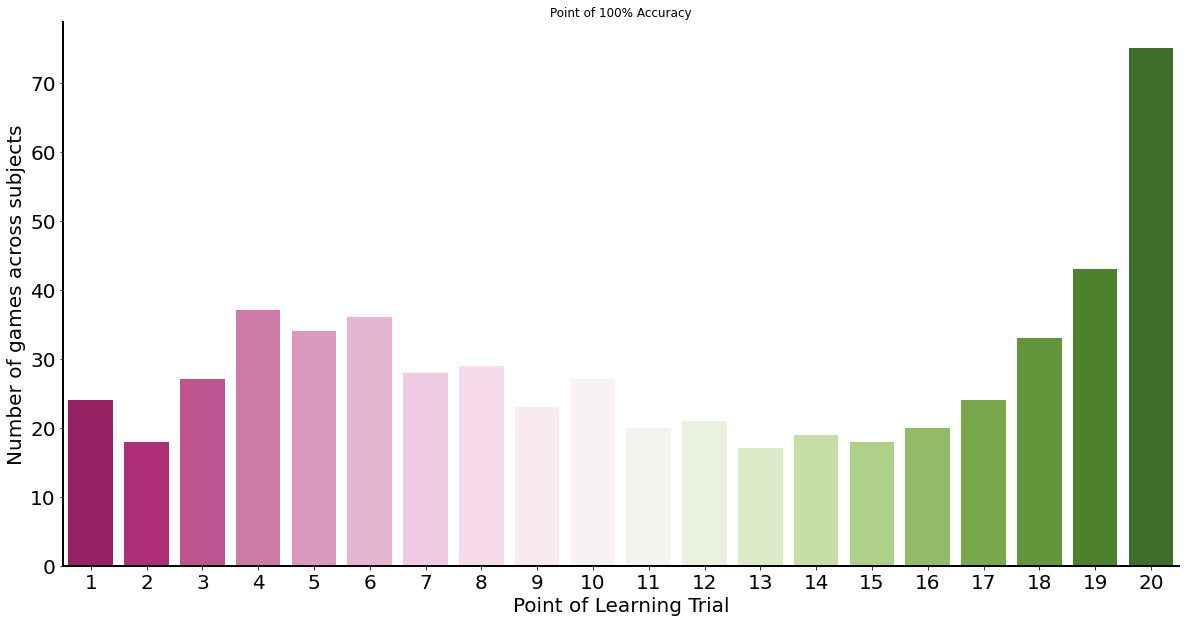

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="PoL", y="SubjGame", data=pol_graph_data, palette="PiYG");
sns.despine()
# ax.set_ylim([0,1.01])
yl = ax.set_ylabel('Number of games across subjects',fontsize = 20);
xl = ax.set_xlabel('Point of Learning Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=20)
ax.set_title('Point of 100% Accuracy')

In [11]:
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,RT,WithinGameTrial,PoL
0,23,1,1,1,6,8,2,5,7,3,...,1.0,1,2,0.0,0.0,1.0,0.0,1.12700,1,18.0
1,23,2,1,2,5,7,1,4,8,3,...,1.0,1,2,0.0,0.0,1.0,0.0,1.08580,2,18.0
2,23,3,1,3,4,7,2,5,9,1,...,0.0,1,2,0.0,0.0,0.0,0.0,1.24420,3,18.0
3,23,4,1,1,4,7,2,5,8,3,...,0.0,1,2,0.0,0.0,1.0,0.0,0.47509,4,18.0
4,23,5,1,1,6,8,2,4,7,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.88090,5,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,1,2,0.0,0.0,1.0,0.0,0.61252,16,6.0
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.89898,17,6.0
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.59331,18,6.0
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,1,2,0.0,0.0,1.0,0.0,0.52019,19,6.0


In [7]:
pol_df = pol_df.drop(columns=['SubjGame', 'SubsequentCorrect'])
behav_data = behav_data.merge(pol_df, on=['Subj', 'Game'], how='left')
behav_data['PoL'] = behav_data['PoL_y']
behav_data = behav_data.drop(columns=['PoL_x', 'PoL_y'])

In [8]:
behav_data['LearnedFeat'] = behav_data['PoL'] < 18
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,RT,WithinGameTrial,PoL
0,23,1,1,1,6,8,2,5,7,3,...,1.0,1,2,0.0,0.0,1.0,False,1.12700,1,18.0
1,23,2,1,2,5,7,1,4,8,3,...,1.0,1,2,0.0,0.0,1.0,False,1.08580,2,18.0
2,23,3,1,3,4,7,2,5,9,1,...,0.0,1,2,0.0,0.0,0.0,False,1.24420,3,18.0
3,23,4,1,1,4,7,2,5,8,3,...,0.0,1,2,0.0,0.0,1.0,False,0.47509,4,18.0
4,23,5,1,1,6,8,2,4,7,3,...,1.0,1,2,0.0,0.0,1.0,False,0.88090,5,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,1,2,0.0,0.0,1.0,True,0.61252,16,6.0
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,True,0.89898,17,6.0
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,True,0.59331,18,6.0
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,1,2,0.0,0.0,1.0,True,0.52019,19,6.0


In [9]:
# import agemap
ageMap = pd.read_csv(os.getcwd() + '/ProcessedData/ageMap.csv')
ageMap

,Age,Subj_id
0,15.12,23
1,15.39,24
2,19.79,25
3,23.32,26
4,14.58,27
5,14.00,28
6,16.73,29
7,17.48,30
8,17.64,31
9,30.36,32


In [10]:
# add age related columns in behavioral dataframe
behav_data["Adult"] = False
behav_data['Age'] = np.nan
for index, row in behav_data.iterrows():
    subj_id = int(row.Subj)
    age = ageMap.loc[ageMap['Subj_id'] == subj_id].Age.item()
    if age < 10:
        behav_data.drop([index]) # remove 67 and 56 because no age info
    else:
        behav_data.loc[index, "Age"] = age
        if age >= 18:
            behav_data.loc[index, "Adult"] = True
behav_data = behav_data[behav_data['Age'].notna()]


In [91]:
# behav_data.to_csv(os.getcwd() + '/ProcessedData/ProcessedBehavioralData.csv', index=False)

## Grab Learning Trials Only

In [11]:
learning_trials = behav_data.loc[behav_data['LearnedFeat']]

In [12]:
learning_trials['AlignedTrial'] = learning_trials['WithinGameTrial'] - learning_trials['PoL']
learning_trials

/var/folders/pt/mk_d2k8923lbq911vprvfth00000gn/T/ipykernel_2652/1915120393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  learning_trials['AlignedTrial'] = learning_trials['WithinGameTrial'] - learning_trials['PoL']


,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,CenterDim,CenterFeat,Correct,LearnedFeat,RT,WithinGameTrial,PoL,Adult,Age,AlignedTrial
20,23,21,2,2,4,8,3,6,9,1,...,0.0,0.0,0.0,True,1.34940,1,7.0,False,15.12,-6.0
21,23,22,2,2,6,9,1,4,8,3,...,0.0,0.0,1.0,True,0.55658,2,7.0,False,15.12,-5.0
22,23,23,2,1,6,9,2,5,7,3,...,0.0,0.0,1.0,True,1.29170,3,7.0,False,15.12,-4.0
23,23,24,2,2,5,8,1,6,9,3,...,0.0,0.0,1.0,True,1.21820,4,7.0,False,15.12,-3.0
24,23,25,2,3,5,9,1,6,7,2,...,0.0,0.0,1.0,True,1.75240,5,7.0,False,15.12,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,0.0,0.0,1.0,True,0.61252,16,6.0,True,22.52,10.0
15196,71,397,20,1,5,8,2,4,9,3,...,0.0,0.0,1.0,True,0.89898,17,6.0,True,22.52,11.0
15197,71,398,20,1,6,7,2,4,9,3,...,0.0,0.0,1.0,True,0.59331,18,6.0,True,22.52,12.0
15198,71,399,20,1,6,7,3,5,8,2,...,0.0,0.0,1.0,True,0.52019,19,6.0,True,22.52,13.0


In [21]:
learning_trials.to_csv(os.getcwd() + '/ProcessedData/Learned_LearningTrials.csv', index=False)

Text(0.5, 1.0, 'Learning Curves over Learning Trials for Learned Subjects')

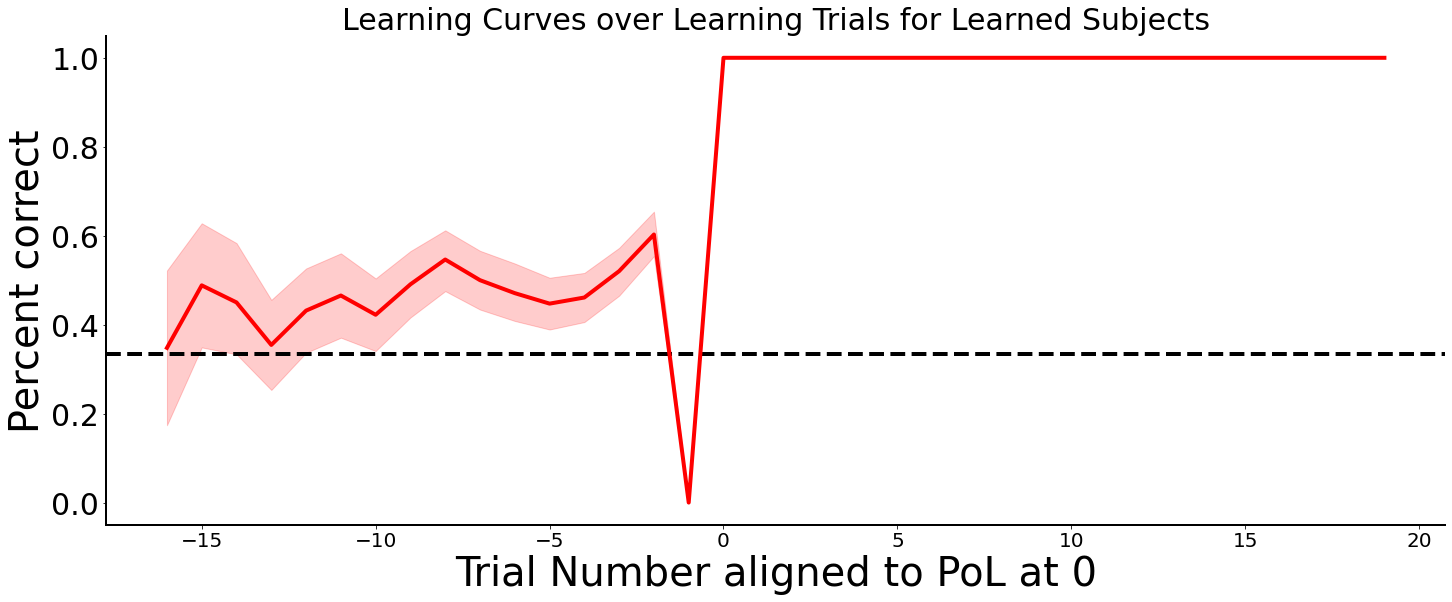

In [13]:
# pre point of learning trials
df = pd.melt(learning_trials, col_level=0, id_vars='AlignedTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(24,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'AlignedTrial', y="value", err_style="band", ci=95, data=df, lw=4, legend=False, color='red')
sns.despine()
# ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0.3,0.8])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial Number aligned to PoL at 0',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);
ax.set_title('Learning Curves over Learning Trials for Learned Subjects', fontsize=30)

In [14]:
# split by age
# split the dataframe into adult and adolescent dataframes
adult_learning = learning_trials.loc[behav_data['Adult']]
adole_learning = learning_trials.loc[behav_data['Adult'] == False]

In [17]:
adult_learning.loc[adult_learning['LearnedFeat']]
adole_learning.loc[adole_learning['LearnedFeat']]

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,RT,WithinGameTrial,PoL,Adult,Age
20,23,21,2,2,4,8,3,6,9,1,...,6,0.0,0.0,0.0,True,1.34940,1,2.0,False,15.12
80,23,81,5,2,4,8,1,6,7,3,...,8,0.0,0.0,0.0,True,1.28720,1,4.0,False,15.12
81,23,82,5,3,5,8,2,4,7,1,...,8,0.0,0.0,0.0,True,0.67802,2,4.0,False,15.12
82,23,83,5,1,6,9,2,4,7,3,...,8,0.0,0.0,0.0,True,0.63642,3,4.0,False,15.12
100,23,101,6,2,5,9,1,4,7,3,...,9,0.0,0.0,1.0,True,1.49370,1,8.0,False,15.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12671,63,272,14,3,6,8,2,5,7,1,...,3,0.0,0.0,0.0,True,0.89077,12,13.0,False,16.90
12720,63,321,17,1,5,9,2,4,8,3,...,3,0.0,0.0,0.0,True,1.19510,1,5.0,False,16.90
12721,63,322,17,2,6,8,3,5,9,1,...,3,0.0,0.0,1.0,True,0.96110,2,5.0,False,16.90
12722,63,323,17,1,6,8,2,5,7,3,...,3,0.0,0.0,0.0,True,0.83162,3,5.0,False,16.90


Text(0.5, 1.0, 'Learning Curves over Learning Trials for Learned Subjects')

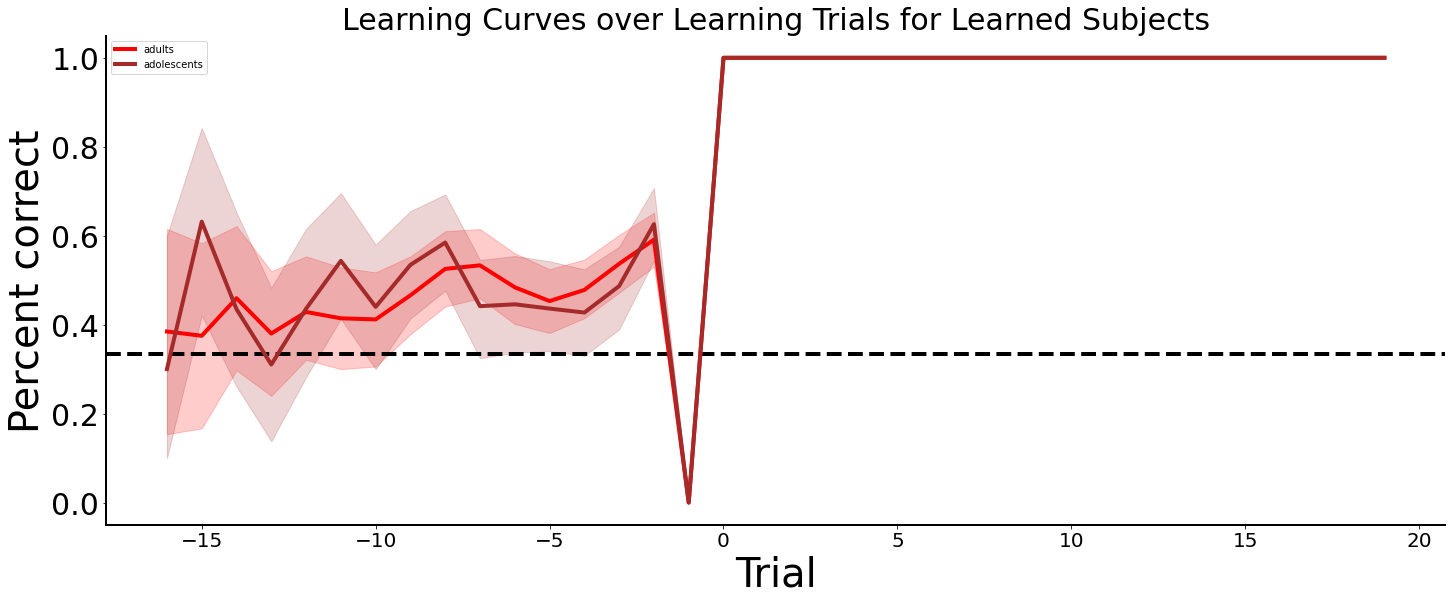

In [16]:
dfu = pd.melt(adult_learning, col_level=0, id_vars='AlignedTrial', value_vars=['Correct'])
dfo = pd.melt(adole_learning, col_level=0, id_vars='AlignedTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(24,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'AlignedTrial', y="value", err_style="band", ci=95, data=dfu, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'AlignedTrial', y="value", err_style="band", ci=95, data=dfo, lw=4, legend='brief', label='adolescents', color='brown')
sns.despine()
# ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0.3,0.8])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);
ax.set_title('Learning Curves over Learning Trials for Learned Subjects', fontsize=30)

In [17]:
relative_looking_time_df = pd.read_csv('ProcessedData/PreChoice_RelativeLookingTimes.csv', index_col='Unnamed: 0')
relative_looking_time_df

FileNotFoundError: [Errno 2] No such file or directory: 'ProcessedData/PreChoice_RelativeLookingTimes.csv'

In [20]:
good_behav_data = behav_data[behav_data['Subj'] != 33]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 66]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 58]
good_behav_data = good_behav_data.reset_index(drop=True)
new_df = pd.merge(good_behav_data, relative_looking_time_df,  how='left', on=['Subj','Trial'])
new_df.to_csv(os.getcwd() + '/ProcessedData/PreChoice_Processed_CombinedBehavioralEyetrackingData.csv', index=False)

In [21]:
new_df = learning_trials.merge(relative_looking_time_df, on=['Subj', 'Trial'], how='left')

In [22]:
adole_combined_df = new_df[new_df['Adult'] == False]
adult_combined_df = new_df[new_df['Adult']]

In [23]:
adult_combined_df.loc[adult_combined_df['LearnedFeat']]
adole_combined_df.loc[adole_combined_df['LearnedFeat']]

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feature7,Feature8,Feature9,Feature10,TotalLookingTime,FeatureEntropy,Animals,Landscapes,Objects,DimensionEntropy
17,23,21,2,2,4,8,3,6,9,1,...,0.000000,0.270655,0.165242,0.415954,1.404,0.450838,0.142450,0.005698,0.435897,0.608944
18,23,81,5,2,4,8,1,6,7,3,...,0.113861,0.148515,0.386139,0.019802,0.808,0.750438,0.252475,0.079208,0.648515,0.754785
19,23,82,5,3,5,8,2,4,7,1,...,0.634454,0.000000,0.000000,0.000000,0.952,0.298805,0.365546,0.000000,0.634454,0.597611
20,23,83,5,1,6,9,2,4,7,3,...,0.617391,0.000000,0.139130,0.000000,0.920,0.416944,0.000000,0.243478,0.756522,0.505234
21,23,101,6,2,5,9,1,4,7,3,...,0.093812,0.000000,0.756487,0.001996,2.004,0.325687,0.147705,0.000000,0.850299,0.382648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,63,272,14,3,6,8,2,5,7,1,...,0.754545,0.000000,0.000000,0.045455,0.880,0.243215,0.000000,0.200000,0.754545,0.486430
4122,63,321,17,1,5,9,2,4,8,3,...,0.000000,0.197719,0.197719,0.011407,1.052,0.637106,0.581749,0.011407,0.395437,0.667245
4123,63,322,17,2,6,8,3,5,9,1,...,0.000000,0.003333,0.190000,0.180000,1.200,0.466380,0.626667,0.000000,0.193333,0.555773
4124,63,323,17,1,6,8,2,5,7,3,...,0.000000,0.000000,0.323810,0.004762,0.840,0.517704,0.671429,0.000000,0.323810,0.575808


In [28]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['DimensionEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['DimensionEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'AlignedTrial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'AlignedTrial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
# ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0,1])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('DimensionEntropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

NameError: name 'adult_combined_df' is not defined

# Dump

In [34]:
pd.DataFrame.from_dict(numCorrectOnSubsequentTrials).sort_values(['Subj','Game'], ascending = (True, True)).reset_index(drop=True)

,Subj,Game,WithinGameTrial,SubsequentCorrect,EightyPercent
0,23.0,1.0,1,15.0,False
1,23.0,1.0,2,14.0,False
2,23.0,1.0,3,13.0,False
3,23.0,1.0,4,13.0,False
4,23.0,1.0,5,12.0,False
...,...,...,...,...,...
15195,71.0,20.0,16,5.0,True
15196,71.0,20.0,17,4.0,True
15197,71.0,20.0,18,3.0,True
15198,71.0,20.0,19,2.0,True


In [19]:
subsequentcorrect_df = pd.DataFrame.from_dict(numCorrectOnSubsequentTrials).sort_values(['Subj','Game'], ascending = (True, True)).reset_index(drop=True) #.rename(columns={"Correct": "SubsequentCorrect"})

Subj                 23.0
Game                  1.0
WithinGameTrial      11.0
SubsequentCorrect     8.0
EightyPercent        11.0
Name: 10, dtype: float64
Subj                 23.0
Game                  1.0
WithinGameTrial      16.0
SubsequentCorrect     4.0
EightyPercent        16.0
Name: 15, dtype: float64
Subj                 23.0
Game                  1.0
WithinGameTrial      18.0
SubsequentCorrect     3.0
EightyPercent        18.0
Name: 17, dtype: float64
Subj                 23.0
Game                  1.0
WithinGameTrial      19.0
SubsequentCorrect     2.0
EightyPercent        19.0
Name: 18, dtype: float64
Subj                 23.0
Game                  1.0
WithinGameTrial      20.0
SubsequentCorrect     1.0
EightyPercent        20.0
Name: 19, dtype: float64
Subj                 23.0
Game                  2.0
WithinGameTrial       1.0
SubsequentCorrect    18.0
EightyPercent         1.0
Name: 20, dtype: float64
Subj                 23.0
Game                  2.0
WithinGameTrial   